In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud, STOPWORDS
import re
import seaborn as sns
import spacy
from textblob import TextBlob
from tqdm import tqdm_notebook
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


### **Loading the Amazon product reviews data**

In [2]:
data = pd.read_csv("/kaggle/input/reviews/reviews.csv")
data


,Reviewer Name,Reviews
0,Ashutosh Yadav,It has good runtime. Regular use may run upto ...
1,PIYUSH,I'm a JBL fan. Compared to JBL (and other high...
2,Ashutosh Yadav,1.Cable quality is moderate.2.Hearing butts it...
3,Ashutosh Yadav,I have been using same model from last one and...
4,Deepak,The product is good but the earphone is not fi...
...,...,...
105,KRISHAN,"Good in battery backup, sound is very good."
106,Good product,Everything is good bass is on the next level b...
107,Good product,ITS BEEN 2 LONG YEARS AND INSPITE OF MY REGULA...
108,Ashutosh Yadav,Thankyou so much Amazon and boat to make this ...


### Replace NaN values with an empty string

In [3]:
data['Reviews'] = data['Reviews'].fillna('')
data

,Reviewer Name,Reviews
0,Ashutosh Yadav,It has good runtime. Regular use may run upto ...
1,PIYUSH,I'm a JBL fan. Compared to JBL (and other high...
2,Ashutosh Yadav,1.Cable quality is moderate.2.Hearing butts it...
3,Ashutosh Yadav,I have been using same model from last one and...
4,Deepak,The product is good but the earphone is not fi...
...,...,...
105,KRISHAN,"Good in battery backup, sound is very good."
106,Good product,Everything is good bass is on the next level b...
107,Good product,ITS BEEN 2 LONG YEARS AND INSPITE OF MY REGULA...
108,Ashutosh Yadav,Thankyou so much Amazon and boat to make this ...


#### **Convert all reviews to lowercase**

In [4]:
data['Reviews'] = data['Reviews'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data

,Reviewer Name,Reviews
0,Ashutosh Yadav,it has good runtime. regular use may run upto ...
1,PIYUSH,i'm a jbl fan. compared to jbl (and other high...
2,Ashutosh Yadav,1.cable quality is moderate.2.hearing butts it...
3,Ashutosh Yadav,i have been using same model from last one and...
4,Deepak,the product is good but the earphone is not fi...
...,...,...
105,KRISHAN,"good in battery backup, sound is very good."
106,Good product,everything is good bass is on the next level b...
107,Good product,its been 2 long years and inspite of my regula...
108,Ashutosh Yadav,thankyou so much amazon and boat to make this ...


#### **Remove punctuation marks**

In [5]:
data['Reviews'] = data['Reviews'].str.replace('[^\w\s]','', regex=True)
data

,Reviewer Name,Reviews
0,Ashutosh Yadav,it has good runtime regular use may run upto 3...
1,PIYUSH,im a jbl fan compared to jbl and other high en...
2,Ashutosh Yadav,1cable quality is moderate2hearing butts its n...
3,Ashutosh Yadav,i have been using same model from last one and...
4,Deepak,the product is good but the earphone is not fi...
...,...,...
105,KRISHAN,good in battery backup sound is very good
106,Good product,everything is good bass is on the next level b...
107,Good product,its been 2 long years and inspite of my regula...
108,Ashutosh Yadav,thankyou so much amazon and boat to make this ...


#### **Remove stop words**

In [6]:
stop_words = set(STOPWORDS)
data['Reviews'] = data['Reviews'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))
data

,Reviewer Name,Reviews
0,Ashutosh Yadav,good runtime regular use may run upto 34 days ...
1,PIYUSH,im jbl fan compared jbl high end brands qualit...
2,Ashutosh Yadav,1cable quality moderate2hearing butts fit eari...
3,Ashutosh Yadav,using model last one half year performance goo...
4,Deepak,product good earphone fitting ear falling
...,...,...
105,KRISHAN,good battery backup sound good
106,Good product,everything good bass next level ear tips heavy...
107,Good product,2 long years inspite regular daily usage still...
108,Ashutosh Yadav,thankyou much amazon boat make earphone thanky...


#### **Number of characters**

In [10]:
data['char_count'] = data['Reviews'].str.len() 
data[['Reviews','char_count']].head()

,Reviews,char_count
0,good runtime regular use may run upto 34 days ...,224
1,im jbl fan compared jbl high end brands qualit...,130
2,1cable quality moderate2hearing butts fit eari...,89
3,using model last one half year performance goo...,98
4,product good earphone fitting ear falling,41


#### **Average Word Length**

In [14]:
def avg_word(sentence):
    words = str(sentence).split()
    if len(words) == 0:
        return 0  # or any other default value you prefer
    else:
        return sum(len(word) for word in words) / len(words)

data['avg_word'] = data['Reviews'].apply(lambda x: avg_word(x))
data[['Reviews','avg_word']].head()

,Reviews,avg_word
0,good runtime regular use may run upto 34 days ...,4.487805
1,im jbl fan compared jbl high end brands qualit...,5.550000
2,1cable quality moderate2hearing butts fit eari...,8.000000
3,using model last one half year performance goo...,6.071429
4,product good earphone fitting ear falling,6.000000


#### **CountVectorizer with N-grams (Bigrams & Trigrams)**

In [20]:
from nltk.corpus import stopwords
ps = PorterStemmer()
corpus = []
for i in tqdm_notebook(range(0, len(data))):
    review = re.sub('[^a-zA-Z]', ' ', data['Reviews'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/110 [00:00<?, ?it/s]

In [21]:
corpus[3]

'use model last one half year perform good suddenli work order model bluetooth earphon'

#### **Applying Countvectorizer**
Creating the Bag of Words model

In [24]:
cv = CountVectorizer(max_features=5000,ngram_range=(1,3))
X = cv.fit_transform(corpus).toarray()

In [25]:
X.shape

(110, 2326)

In [26]:
cv.get_feature_names()[:20]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['aan',
 'aan par',
 'aan par nhi',
 'accha',
 'accha hai',
 'accha hai favorit',
 'accha hai ye',
 'acchi',
 'acchi hai',
 'acchi hai music',
 'accord',
 'accord price',
 'accord price work',
 'achhi',
 'achhi hai',
 'achhi hai price',
 'actual',
 'actual posit',
 'actual posit betterhowev',
 'agent']

In [28]:
cv.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 3),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [29]:
count_df = pd.DataFrame(X, columns=cv.get_feature_names())
count_df

,aan,aan par,aan par nhi,accha,accha hai,accha hai favorit,accha hai ye,acchi,acchi hai,acchi hai music,...,year inspit,year inspit regular,year perform,year perform good,yearbut,yearbut time,yearbut time within,your,your play,your play mostli
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
108,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### **TF-IDF Vectorizer**

In [35]:
from nltk.corpus import stopwords
ps = PorterStemmer()
corpus = []
for i in tqdm_notebook(range(0, len(data))):
    review = re.sub('[^a-zA-Z]', ' ', data['Reviews'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/110 [00:00<?, ?it/s]

In [31]:
corpus[4]

'product good earphon fit ear fall'

#### **TFidf Vectorizer**

In [36]:
tfidf_v=TfidfVectorizer(max_features=5000,ngram_range=(1,3))
X=tfidf_v.fit_transform(corpus).toarray()

In [37]:
X.shape

(110, 2326)

In [38]:
tfidf_v.get_feature_names()[:20]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['aan',
 'aan par',
 'aan par nhi',
 'accha',
 'accha hai',
 'accha hai favorit',
 'accha hai ye',
 'acchi',
 'acchi hai',
 'acchi hai music',
 'accord',
 'accord price',
 'accord price work',
 'achhi',
 'achhi hai',
 'achhi hai price',
 'actual',
 'actual posit',
 'actual posit betterhowev',
 'agent']

In [39]:
tfidf_v.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 3),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [40]:
count_df = pd.DataFrame(X, columns=tfidf_v.get_feature_names())
count_df


,aan,aan par,aan par nhi,accha,accha hai,accha hai favorit,accha hai ye,acchi,acchi hai,acchi hai music,...,year inspit,year inspit regular,year perform,year perform good,yearbut,yearbut time,yearbut time within,your,your play,your play mostli
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.166301,0.166301,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.154394,0.154394,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


#### **Named Entity Recognition (NER)**

In [42]:
reviews=[data.strip() for data in data.Reviews] # remove both the leading and the trailing characters
reviews=[Reviews for Reviews in reviews if Reviews] # removes empty strings, because they are considered in Python as False
# Joining the list into one string/text
reviews_text=' '.join(reviews)
reviews_text[0:1000]

'good runtime regular use may run upto 34 days casual use may run weeks thing little heavy may wish switch earbuds low runtimeelse good feel may sharp sound ptron earbuds cheaper rate u short money go boat one will safer ears im jbl fan compared jbl high end brands quality upto mark price delivering expected costbattery charging backup 55bass 45treble 25 1cable quality moderate2hearing butts fit earings3magnet power low4noise control moderate using model last one half year performance good suddenly working ordered model bluetooth earphones product good earphone fitting ear falling awsome headphones neckband awesome good product purchase ears started hurt hour overall sound quality good overall okay using 2 months now audio mic quality good expected major highlight neckband battery battery life really astonished use around 3 hours day easily lasts 10 12 days easily single full chargemay vary depending upon volume used usually use around 30 plus charges rapidly takes less hour chargethe 

In [43]:
nlp=spacy.load('en_core_web_sm')

one_block=reviews_text[:1000]
doc_block=nlp(one_block)
spacy.displacy.render(doc_block,style='ent',jupyter=True)

In [44]:
for token in doc_block[:50]:
    print(token,token.pos_)  

good ADJ
runtime NOUN
regular ADJ
use NOUN
may AUX
run VERB
upto ADV
34 NUM
days NOUN
casual ADJ
use NOUN
may AUX
run VERB
weeks NOUN
thing NOUN
little ADJ
heavy ADJ
may AUX
wish VERB
switch NOUN
earbuds NOUN
low VERB
runtimeelse ADV
good ADJ
feel NOUN
may AUX
sharp VERB
sound PROPN
ptron PROPN
earbuds NOUN
cheaper ADJ
rate NOUN
u PROPN
short ADJ
money NOUN
go VERB
boat NOUN
one PRON
will AUX
safer VERB
ears NOUN
i PROPN
m VERB
jbl PROPN
fan PROPN
compared VERB
jbl NOUN
high ADJ
end NOUN
brands NOUN


#### **Filtering the nouns and verbs only**

In [45]:
one_block=reviews_text
doc_block=nlp(one_block)
nouns_verbs=[token.text for token in doc_block if token.pos_ in ('NOUN','VERB')]
print(nouns_verbs[100:200])

['pairing', 'mode', 'paired', 'connecting', 'phone', 'connect', 'phone', 'shows', 'problem', 'connecting', 'device', 'cases', 'restarting', 'fixes', 'problemhowever', 'cases', 'issue', 'product', 'boat', 'buy', 'budget', 'love', 'product', 'using', 'months', 'sort', 'issue', 'recommend', 'u', 'buy', 'product', 'mindblowing', 'purchased', 'delivery', 'let', 'product', 'auto', 'auto', 'रसव', 'product', 'product', 'issue', 'using', 'auto', 'notification', 'voice', 'device', 'switching', 'switching', 'software', 'error', 'bass', 'product', 'quality', 'quality', 'linking', 'usage', 'use', 'walk', 'comment', 'battery', 'backup', 'came', 'week', 'charged', 'use', 'hours', 'part', 'walk', 'earpods', 'come', 'ear', 'weight', 'wire', 'mouthpiece', 'ear', 'phones', 'observation', 'pros', 'audio', 'quality', 'combination', 'bass', 'clarity', 'good2', 'battery', 'charges', 'issue', 'battery', 'backup3', 'calling', 'noise', 'cancellation', 'goodcons', 'wire', 'quality', 'looks', 'considering', 'pric

In [46]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer()

X=cv.fit_transform(nouns_verbs)
sum_words=X.sum(axis=0)

words_freq=[(word,sum_words[0,idx]) for word,idx in cv.vocabulary_.items()]
words_freq=sorted(words_freq, key=lambda x: x[1], reverse=True)

wd_df=pd.DataFrame(words_freq)
wd_df.columns=['word','count']
wd_df[0:10] # viewing top ten results

,word,count
0,quality,39
1,product,33
2,battery,23
3,sound,17
4,use,14
5,ear,14
6,boat,11
7,life,11
8,backup,10
9,bass,9


<AxesSubplot:title={'center':'Top 10 nouns and verbs'}, xlabel='word'>

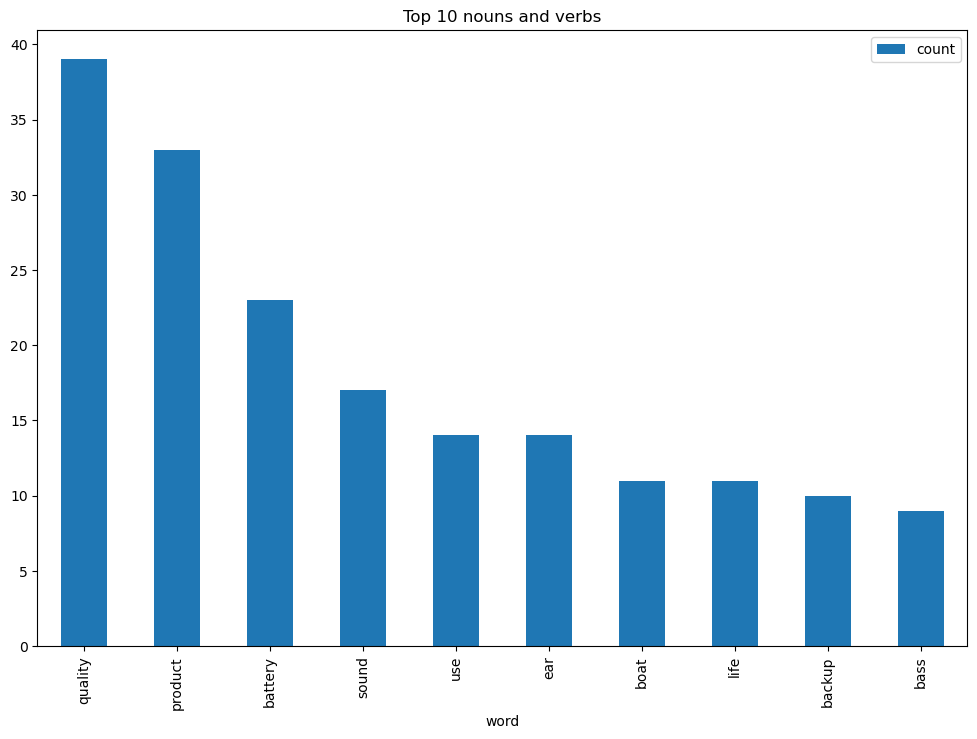

In [47]:
wd_df[0:10].plot.bar(x='word',figsize=(12,8),title='Top 10 nouns and verbs')

### Performing sentiment analysis on each review using TextBlob

In [7]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity
    if Sentiment > 0:
        return 'positive'
    elif Sentiment < 0:
        return 'negative'
    else:
        return 'neutral'


data["Sentiment"] = data["Reviews"].apply(get_sentiment)
data

,Reviewer Name,Reviews,Sentiment
0,Ashutosh Yadav,good runtime regular use may run upto 34 days ...,0.078750
1,PIYUSH,im jbl fan compared jbl high end brands qualit...,0.030000
2,Ashutosh Yadav,1cable quality moderate2hearing butts fit eari...,0.200000
3,Ashutosh Yadav,using model last one half year performance goo...,0.133333
4,Deepak,product good earphone fitting ear falling,0.600000
...,...,...,...
105,KRISHAN,good battery backup sound good,0.600000
106,Good product,everything good bass next level ear tips heavy...,0.020000
107,Good product,2 long years inspite regular daily usage still...,0.441667
108,Ashutosh Yadav,thankyou much amazon boat make earphone thanky...,0.200000


#### **Creating a word cloud to show the most frequent words in the reviews**

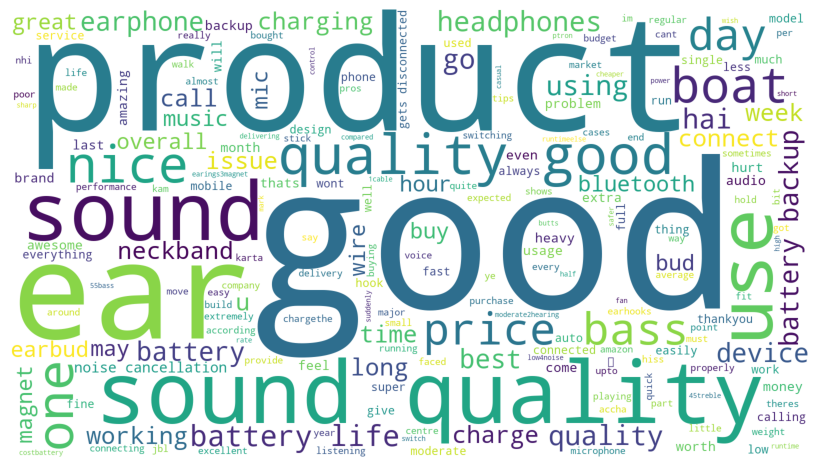

In [8]:
wordcloud = WordCloud(width=1600, height=900, background_color="white", min_font_size=10).generate(" ".join(data["Reviews"]))
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

<AxesSubplot:xlabel='Sentiment', ylabel='Count'>

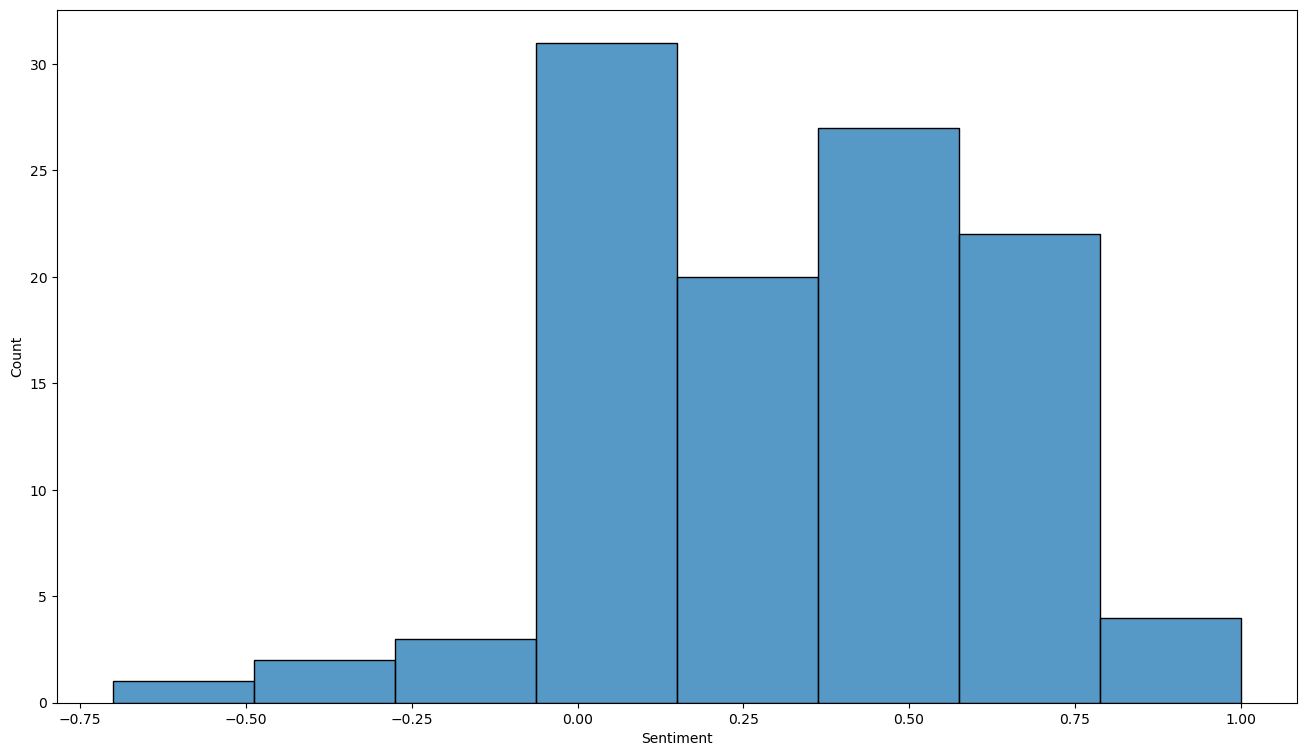

In [48]:
plt.figure(figsize=(16, 9))
sns.histplot(data['Sentiment'])

In [52]:
type_ = ["Positive", "Neutral", "Negative"]
fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Pie(labels=type_, values=data['Sentiment'].value_counts(), name="sentiment"))

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name", textfont_size=16)

fig.update_layout(
    title_text="Sentiment Analysis",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Sentiment', x=0.5, y=0.5, font_size=20, showarrow=False)])
fig.show()

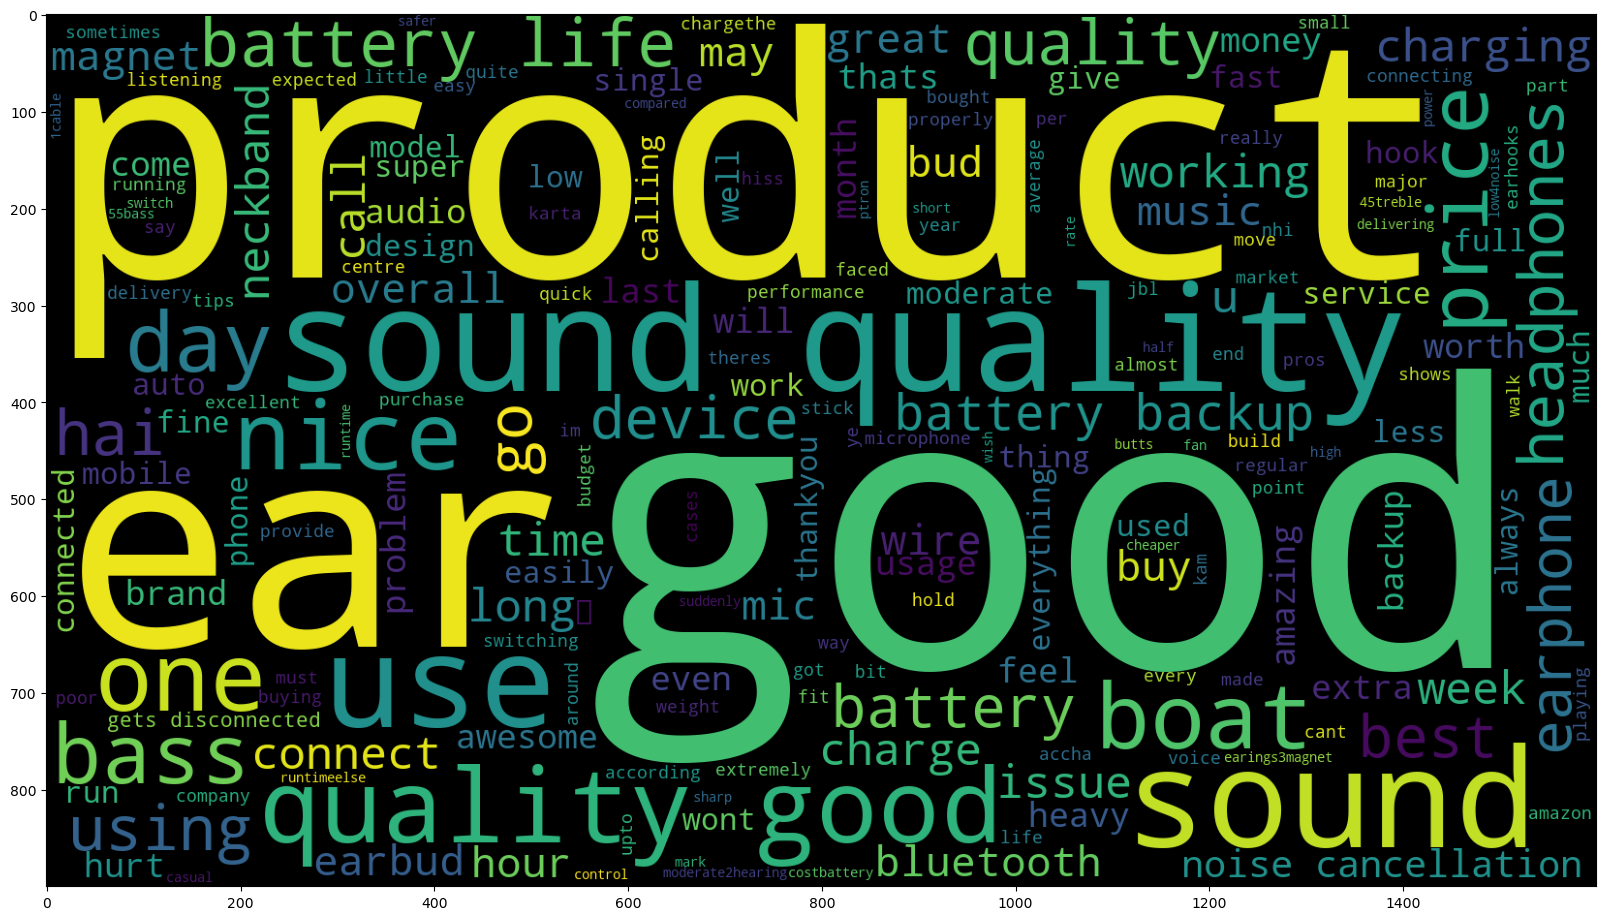

In [54]:
allWords_ = ' '.join([review for review in data[:500]['Reviews']])
f, axes = plt.subplots(figsize=(20,12))
wordcloud= WordCloud(
        background_color = 'black',
        width = 1600,
        height =900).generate(allWords_)
plt.imshow(wordcloud)

#### **Most common words in positive Review**

In [55]:
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=1600, height=900, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate(all_words)

    plt.figure(figsize=(16, 9))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

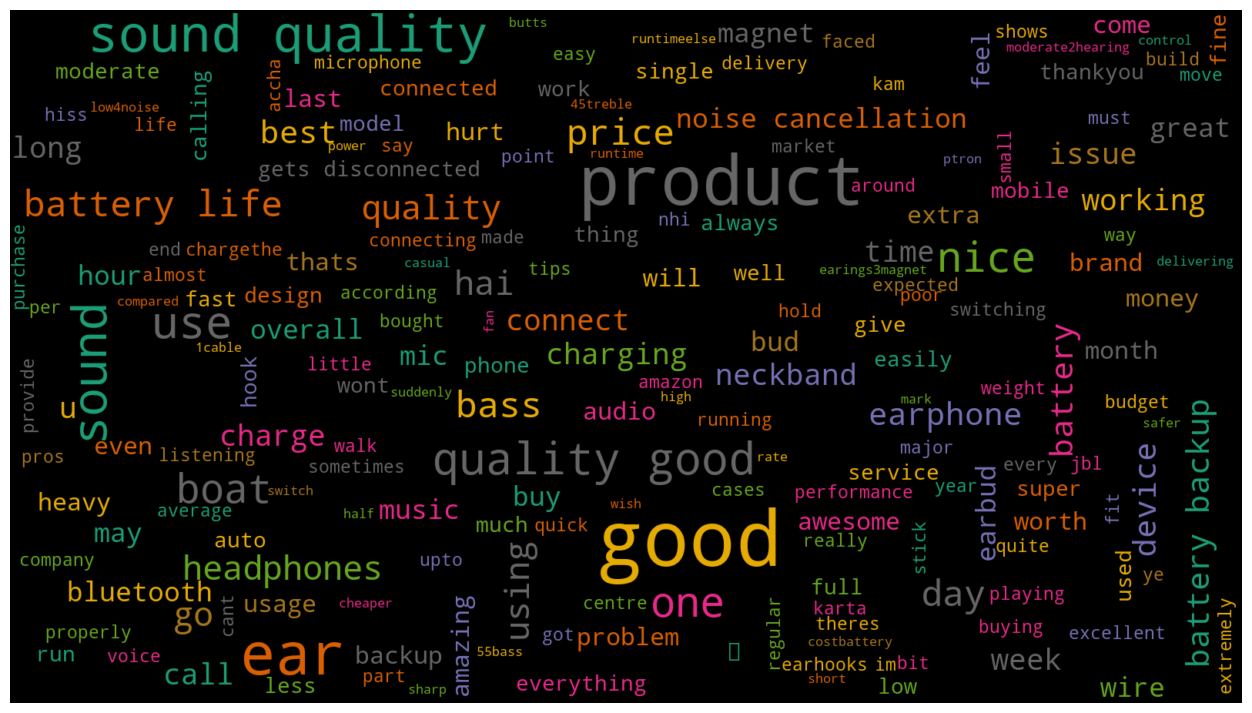

In [58]:
all_words = ' '.join([text for text in data['Reviews']])
generate_wordcloud(all_words)